In [13]:
import os,sys
import h5py as h5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def make_histo(dic, station=''):

    fs = 12
    plt.title('Private/Restricted records for ' + station, fontsize = fs)
    
    plt.hist([dic['free'],dic['private']],
              histtype = 'stepfilled',
              color = ['blue','orange'],
              bins = 50,
              label = ['Free', 'Restricted'] )

    plt.grid(ls=':' , color='lightgray')

    plt.legend(fontsize = fs-2, loc = 'upper left')
    if not os.path.isdir('Plots'):
        os.mkdir('Plots')
        
    if not os.path.isdir('Plots/policy/'):
        os.mkdir('Plots/policy/')

    plt.tight_layout()
    plt.savefig('Plots/policy/policy_histo_' + station + '.png',
                dpi = 150 )
    

    
def get_data(file, station = ''):
    
    dic = {'free':[],
           'restricted':[],
           'station': station }

    F = h5.File(file)

    indices = np.array(F['recordindex'][:])
    dates = np.array(F['recordtimestamp'][:])

    policy = np.array(F['observations_table']['data_policy_licence'][:])
    policy = policy[indices]

    private = np.where(policy == 4 )[0]
    free = np.where(policy == 0)[0]

    free_dates = 1900 + (dates[free]/ (365.25*60*60*24) )
    private_dates = 1900 + dates[private] / (365.25*60*60*24) 

    dic['free'] = free_dates
    dic['private'] = private_dates
    
    return dic

    

In [14]:
'''
f1 = '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-17281_CEUAS_merged_v1.nc'
dic = get_data(f1, station = '17281')
dummy_plot = make_histo(dic, station= '17281')
'''

"\nf1 = '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-17281_CEUAS_merged_v1.nc'\ndic = get_data(f1, station = '17281')\ndummy_plot = make_histo(dic, station= '17281')\n"

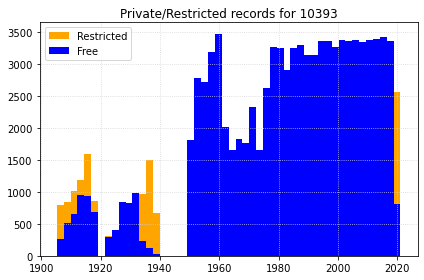

In [15]:
f = '/raid60/scratch/federico/MERGED_26MAY2021/0-20001-0-10393_CEUAS_merged_v1.nc'
dic = get_data(f, station = '10393')
dummy_plot = make_histo(dic, station= '10393')

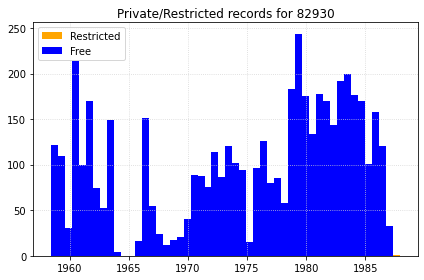

In [16]:
f = '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-82930_CEUAS_merged_v1.nc'
dic = get_data(f, station = '82390')
dummy_plot = make_histo(dic, station= '82930')

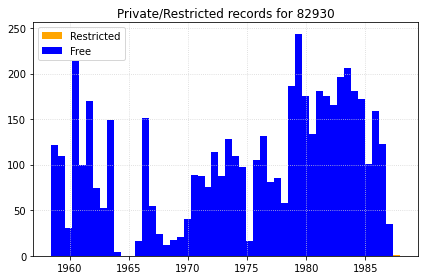

In [18]:
f='/raid8/srvx1/federico/GitHub/CEUAS_master_APRIL2021/CEUAS/CEUAS/public/merge/PROVA/0-20000-0-82930_CEUAS_merged_v1.nc'
dic = get_data(f, station = '82390')
dummy_plot = make_histo(dic, station= '82930')


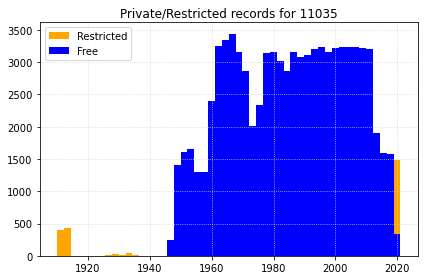

In [19]:
f = '/raid60/scratch/federico/MERGED_26MAY2021/0-20001-0-11035_CEUAS_merged_v1.nc'
dic = get_data(f, station = '11035')
dummy_plot = make_histo(dic, station= '11035')